# Lambda Q - Watkin's $Q(\lambda)$

The idea of eligibility trace can also be applied to q-learning, however some special care is required, to make sure we are still learning the greedy policy. The big difference is that whenever we take an exploratory action we should reset all eligibility traces, as the rewards we will be getting no longer correspond to the greedy policy.

So after we updata $ET(s_t, a_t)$ like we do in $\lambda$-SARSA, we do updates to our $Q$ function by: 

$$\delta = R_t + \gamma * max_{a \in A}Q(s_{t+1}, a) - Q(s_{t}, a_{t})$$
$$ Q(s, a) \leftarrow Q(s, a) + \alpha \delta ET(s, a) $$

And then we look ahead to $a_{t+1}$, to see if we are going to explore, if so we reset $ET$, else we do normal updates 

$$ ET(s,a) \leftarrow
    \begin{cases}
        \begin{align}
            &\lambda \gamma ET(s,a) \: \: \: \forall (s, a) \in S \times A &\textrm{if }a_{t+1} = argmax_{a \in A}Q(s_{t+1}, a) \\
            &0  &\textrm{otherwise}\\
        \end{align}
    \end{cases}
$$

Then we proced to do everything normal gpi.

In [1]:
import sys

sys.path.append("../..")

import numpy as np
import matplotlib.pyplot as plt
import itertools

from exploring_agents import LambdaQAgent
from exploring_agents.training import run_episode, train_agent
from grid_world.action import Action
from grid_world.grid_world import GridWorld
from grid_world.visualization.format_objects import (
    get_policy_rec_str,
    get_policy_eval_str,
    get_world_str,
)
from exploring_agents.commons.dacaying_functions import get_linear_decay, get_exp_decay
from utils.returns import returns_from_reward
from utils.policy import get_policy_rec, get_random_policy, sample_action
from notebooks.utils.worlds import small_world_03
from notebooks.utils.basics import basic_actions, basic_reward
from notebooks.utils.experimentation import (
    get_exp_results,
    get_results,
    moving_average,
    moving_min,
    get_summary_df,
)


np.random.seed(13)

In [2]:
alpha = 0.3
epsilon = 0.01
gworld = small_world_03
print(get_world_str(gworld))

6                ✘ 

5 ☠  ☠     █     █ 

4          █       

3    ☠  ☠  █  █    

2                  

1    █  █  █  █    

0 ⚐                

  0  1  2  3  4  5 


In [3]:
agent = LambdaQAgent(
    reward_function=basic_reward,
    actions=basic_actions,
    gamma=1,
    alpha=alpha,
    epsilon=epsilon,
    et_lambda=0.7,
)

episode_lengths, episode_returns = train_agent(
    agent=agent, world=small_world_03, episodes=100
)
pi_r = get_policy_rec(agent.policy, small_world_03, agent.actions)

print(get_policy_rec_str(pi_r, small_world_03))

 ↑  ↑  →  →  →  ✘ 

 ☠  ☠  ←  █  ↑  █ 

 →  ↑  ↓  █  ↑  ← 

 ←  ☠  ☠  █  █  ↑ 

 ←  ↓  →  ↑  ←  ↑ 

 ↓  █  █  █  █  ↑ 

 →  →  →  →  →  ↑ 




Well this is already a first surprise, the agent is taking the long, non-greedy path. Lets see what happens if we decrease $\lambda$

In [4]:
agent = LambdaQAgent(
    reward_function=basic_reward,
    actions=basic_actions,
    gamma=1,
    alpha=alpha,
    epsilon=epsilon,
    et_lambda=0.1,
)

episode_lengths, episode_returns = train_agent(
    agent=agent, world=small_world_03, episodes=100
)
pi_r = get_policy_rec(agent.policy, small_world_03, agent.actions)

print(get_policy_rec_str(pi_r, small_world_03))

 ←  ←  →  →  →  ✘ 

 ☠  ☠  ↑  █  ↑  █ 

 →  →  ↑  █  ↑  ← 

 ↑  ☠  ☠  █  █  ↑ 

 ↑  ←  ↓  ↓  →  ↑ 

 ↑  █  █  █  █  ↑ 

 ↑  →  →  →  ↑  ↑ 




Here the agent is taking the greedy path, as expected for Q-learning.

So, for a high value of $\lambda$, does the agent eventually gets to the greedy path?

In [5]:
agent = LambdaQAgent(
    reward_function=basic_reward,
    actions=basic_actions,
    gamma=1,
    alpha=0.1,
    epsilon=0.2,
    et_lambda=0.7,
)

episode_lengths, episode_returns = train_agent(
    agent=agent, world=small_world_03, episodes=10000
)
pi_r = get_policy_rec(agent.policy, small_world_03, agent.actions)

print(get_policy_rec_str(pi_r, small_world_03))

 →  →  →  →  →  ✘ 

 ☠  ☠  ↑  █  ↑  █ 

 →  →  ↑  █  ↑  ← 

 ↑  ☠  ☠  █  █  ↑ 

 ↑  →  →  →  →  ↑ 

 ↑  █  █  █  █  ↑ 

 ↑  →  →  →  →  ↑ 




It seems to be the case if we add a high enough exploration rate.

## Hyperparameters

Lets check how the new parameters affect performance. We will examine the "kind" and $\lambda$ values of the eligibility trace.

In [6]:
training_rounds = 200
episodes = 100

base_arguments = {
    "reward_function": basic_reward,
    "actions": basic_actions,
    "alpha": alpha,
    "epsilon": epsilon,
}
arguments = {
    "et_kind": ["accumulating", "dutch", "replacing"],
    "et_lambda": [0.01, 0.1, 0.5],
}

results = get_exp_results(
    LambdaQAgent,
    small_world_03,
    base_arguments,
    arguments,
    episodes,
    training_rounds,
)

results_df = get_summary_df(results)
display(
    results_df.round(
        {
            "average_round_reward": 2,
            "std_round_reward": 2,
            "average_reward_final_10": 2,
            "std_reward_final_10": 2,
        }
    )
)

,et_kind,et_lambda,average_round_reward,std_round_reward,average_reward_final_10,std_reward_final_10,shortest_run
5,dutch,0.50,-2659.00,135.07,-13.21,5.22,13
8,replacing,0.50,-2682.48,140.57,-13.34,6.49,13
2,accumulating,0.50,-2694.67,160.68,-13.27,5.91,13
4,dutch,0.10,-3886.10,177.83,-12.79,11.41,11
1,accumulating,0.10,-3897.56,166.76,-13.05,12.56,11
7,replacing,0.10,-3903.86,169.72,-13.19,12.90,11
0,accumulating,0.01,-4034.56,172.63,-13.40,13.82,11
6,replacing,0.01,-4040.15,172.12,-13.30,12.92,11
3,dutch,0.01,-4045.63,167.45,-13.80,15.05,11


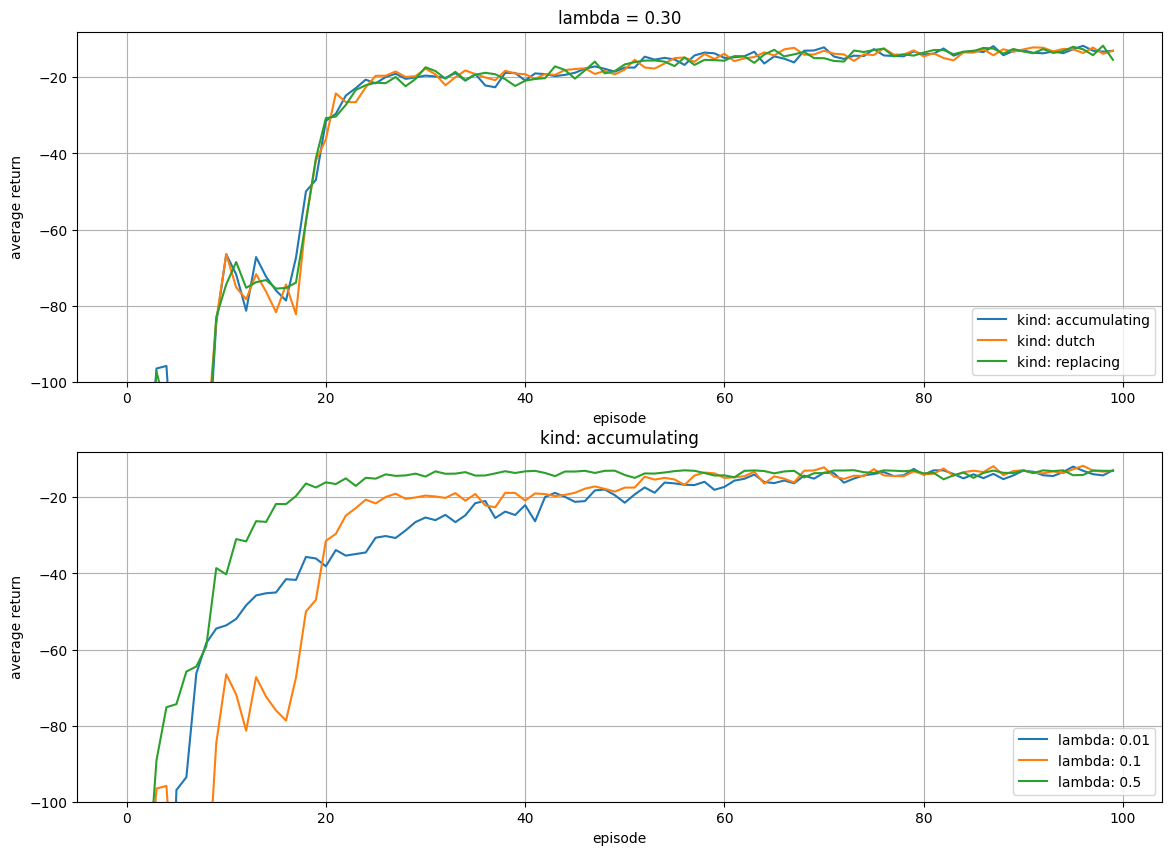

In [7]:
fig, axs = plt.subplots(2, figsize=(14, 10))

for (params, values) in results:
    if params["et_lambda"] == 0.10:
        axs[0].plot(
            np.mean(np.array(values[0]), axis=0), label=f'kind: {params["et_kind"]}'
        )

axs[0].set(xlabel="episode", ylabel="average return", ylim=[-100, -8])
axs[0].grid()
axs[0].legend(loc="lower right")
axs[0].set_title("lambda = 0.30")

for (params, values) in results:
    if params["et_kind"] == "accumulating":
        axs[1].plot(
            np.mean(np.array(values[0]), axis=0), label=f'lambda: {params["et_lambda"]}'
        )

axs[1].set(xlabel="episode", ylabel="average return", ylim=[-100, -8])
axs[1].grid()
axs[1].legend(loc="lower right")
axs[1].set_title("kind: accumulating")


plt.show()

Just as with $\lambda$-sarsa, the parameter $\lambda$ does seem to have a nice impact over our algorithm, while the kind seems almost irrelevant; lets focus a little more on $\lambda$ then. It is also clear from the results that sometimes the agent seems to be sticking to the safe path, lets take a look this, by focusing on episode lengths.

In [8]:
training_rounds = 200
episodes = 100

base_arguments = {
    "reward_function": basic_reward,
    "actions": basic_actions,
    "alpha": alpha,
    "epsilon": epsilon,
}
arguments = {"et_lambda": [0.01, 0.1, 0.3, 0.7]}

results = get_exp_results(
    LambdaQAgent,
    small_world_03,
    base_arguments,
    arguments,
    episodes,
    training_rounds,
)

results_df = get_summary_df(results)
display(
    results_df.round(
        {
            "average_round_reward": 2,
            "std_round_reward": 2,
            "average_reward_final_10": 2,
            "std_reward_final_10": 2,
        }
    )
)

,et_lambda,average_round_reward,std_round_reward,average_reward_final_10,std_reward_final_10,shortest_run
3,0.70,-2307.54,129.36,-13.40,6.05,13
2,0.30,-3289.89,239.16,-13.30,8.98,11
1,0.10,-3888.70,154.12,-13.02,12.55,11
0,0.01,-4045.84,184.05,-13.83,14.50,11


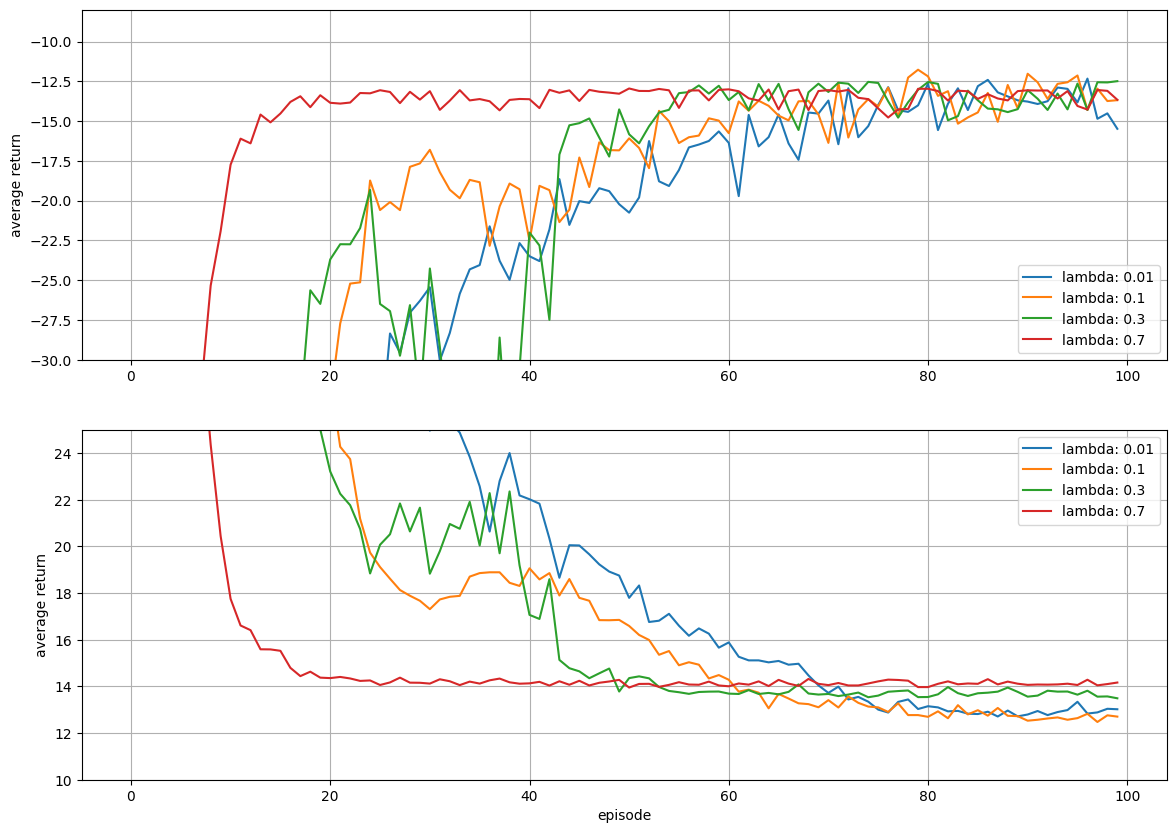

In [9]:
fig, axs = plt.subplots(2, figsize=(14, 10))

for (params, values) in results:
    axs[0].plot(
        np.mean(np.array(values[0]), axis=0), label=f'lambda: {params["et_lambda"]}'
    )

axs[0].set(ylabel="average return", ylim=[-30, -8])
axs[0].grid()
axs[0].legend(loc="lower right")

for (params, values) in results:
    axs[1].plot(
        np.mean(np.array(values[1]), axis=0), label=f'lambda: {params["et_lambda"]}'
    )

axs[1].set(xlabel="episode", ylabel="average return", ylim=[10, 25])
axs[1].grid()
axs[1].legend(loc="upper right")


plt.show()

It is pretty that from $\lambda=0.7$ that agent is going for the safe path, and it also learns it quite fast. For 0.01 and 0.1 it seems like the agent learns the greedy path, while for $\lambda=0.3$ it looks to me that sometimes he goes for one path and sometimes the other, which is also quite curious.

## Long Runs

Above we managed to get the agent to learn the greedy policy by setting a high exploration rate, together with a high value for lambda. However if we are using a low exploration, even in a long run it seems preety difficult for the agent to change his behaviour.

To focus on the agent behaviour lets just look at the shortest runs it gets on a 20 round window for different values of $\epsilon$. The short run takes 11 steps, while the long one takes 13. 

In [3]:
training_rounds = 1
episodes = int(1e4)
alpha = 0.1

base_arguments = {
    "reward_function": basic_reward,
    "actions": basic_actions,
    "alpha": alpha,
    "et_lambda": 0.7,
}
arguments = {"epsilon": [0.01, 0.1, 0.2, 0.3]}
long_run_results = get_exp_results(
    LambdaQAgent,
    small_world_03,
    base_arguments,
    arguments,
    episodes,
    training_rounds,
)

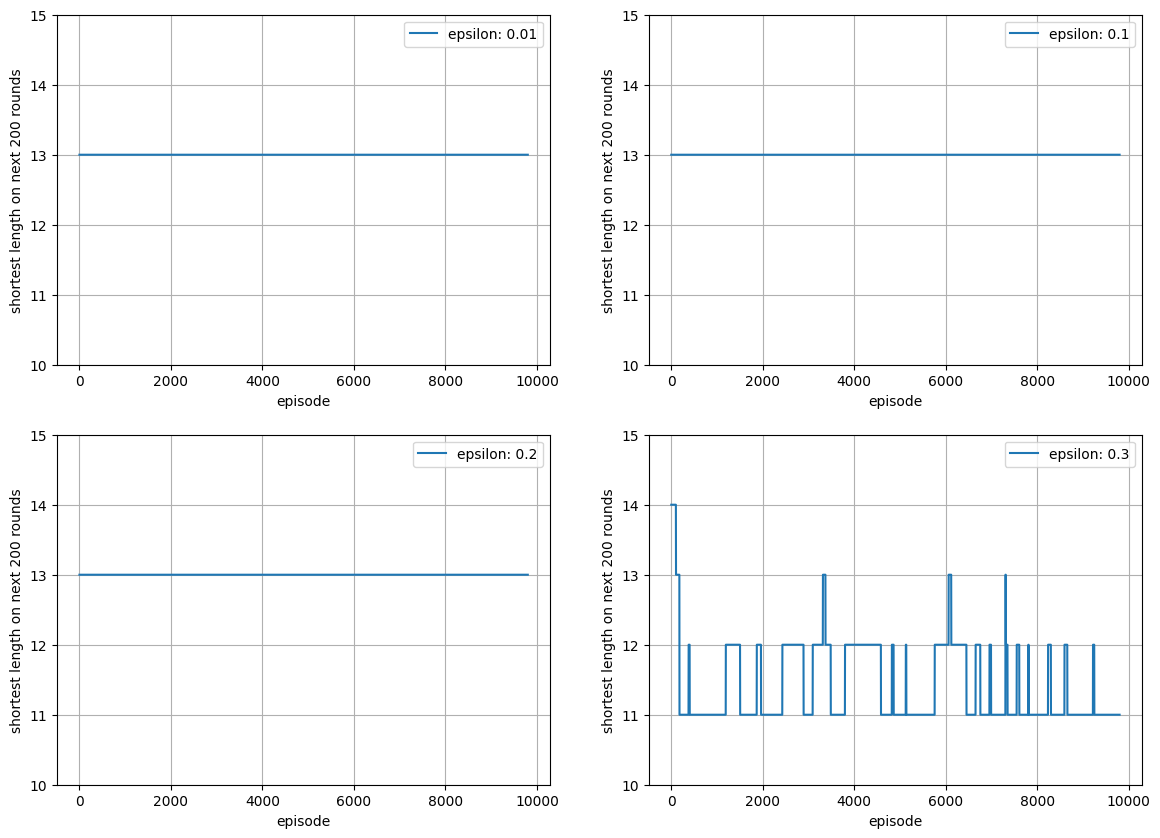

In [4]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
mv_average_rounds = 200
k = 200

for i, (params, values) in enumerate(long_run_results):

    v = np.array(values[1][0])
    axs[i // 2, i % 2].plot(
        moving_min(v, k),
        label=f'epsilon: {params["epsilon"]}',
    )

    axs[i // 2, i % 2].set(
        xlabel="episode", ylabel=f"shortest length on next {k} rounds", ylim=[10, 15]
    )
    axs[i // 2, i % 2].grid()
    axs[i // 2, i % 2].legend(loc="upper right")


plt.show()

So the agent did change behaviour for a high values of  $\epsilon$, which is expected. The last plot may look a bit confusing, but what is going on is that, although the agent is in the short path, it explores so much that it barely ever takes only 11 steps to finish a run.

## Lambda Decay

On the book it is mentioned that having $\lambda$ change over time may be a good strategy. There the authors suggest some fancy methods; here lets just take a look at what happens if we decay it episode by episode.

In [3]:
training_rounds = 1
episodes = int(1e4)
alpha = 0.1

base_arguments = {
    "reward_function": basic_reward,
    "actions": basic_actions,
    "lambda_decay": get_exp_decay(decay_lambda=1e-3, min_value=1e-4),
    "alpha": alpha,
    "et_lambda": 0.7,
}
arguments = {"epsilon": [0.01, 0.1, 0.2, 0.3]}
decay_results = get_exp_results(
    LambdaQAgent,
    small_world_03,
    base_arguments,
    arguments,
    episodes,
    training_rounds,
)

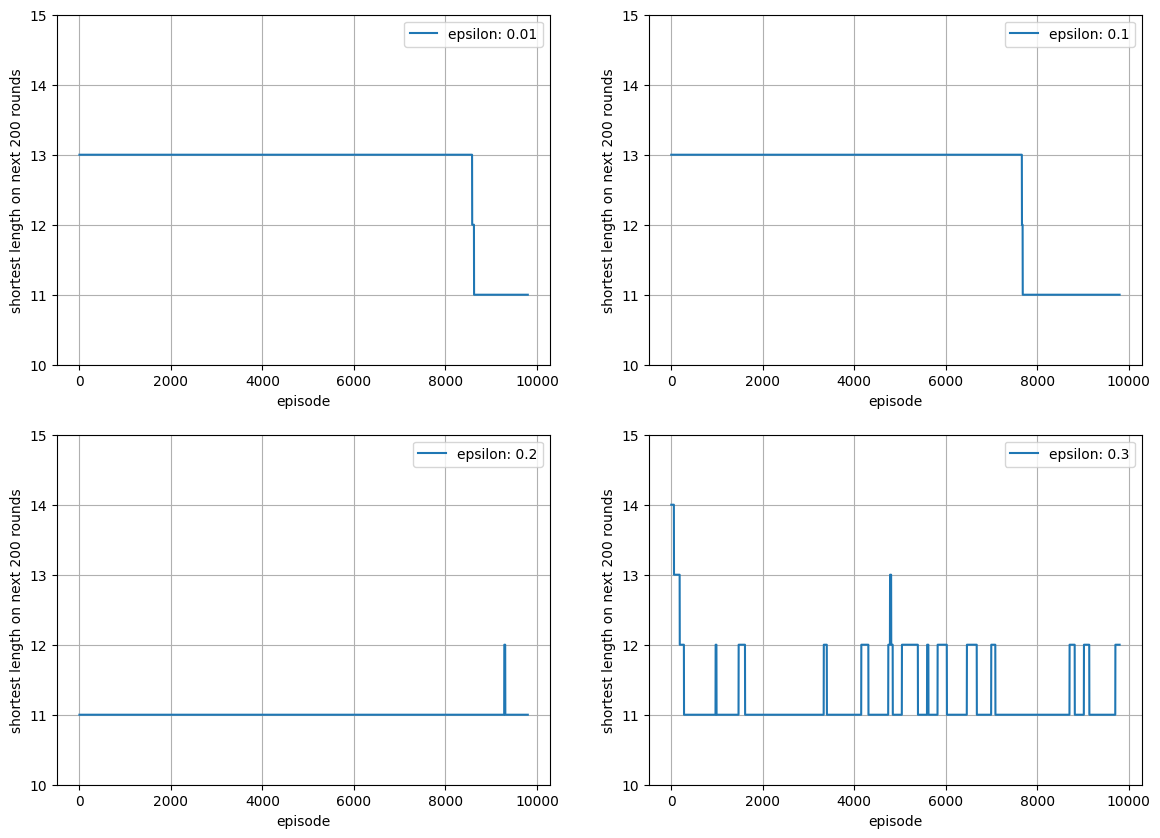

In [4]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
mv_average_rounds = 200
k = 200

for i, (params, values) in enumerate(decay_results):

    v = np.array(values[1][0])
    axs[i // 2, i % 2].plot(
        moving_min(v, k),
        label=f'epsilon: {params["epsilon"]}',
    )

    axs[i // 2, i % 2].set(
        xlabel="episode", ylabel=f"shortest length on next {k} rounds", ylim=[10, 15]
    )
    axs[i // 2, i % 2].grid()
    axs[i // 2, i % 2].legend(loc="upper right")


plt.show()

Pretty cool, we did manage to get the agent to change its behaviour by decaying $\lambda$. 